# Convolutional Neural Networks

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In this session we will understand:
- what automatic differentiation is and how it is used to calculate gradients in neural netowrks
- what are convolutions and how they are used to process digital signals
- how convolutional neural networks are used to analyze images
- what is regularization 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from autograd import grad
import autograd.numpy as np
from autograd.scipy.signal import convolve
import pandas as pd
import scipy.stats
import scipy.optimize
import scipy.misc
import scipy.ndimage
import seaborn as sns
sns.set(
    style='ticks'
)

These cells, until the heading, are similar to those in the [FFN session](FFN.ipynb).

Loading the data:

In [2]:
from tensorflow import keras
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [4]:
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train.reshape(nsamples, nfeatures)
X_test = X_test.reshape(-1, nfeatures)

In [5]:
# if we are already using keras, we can use it for one-hot encoding, too
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

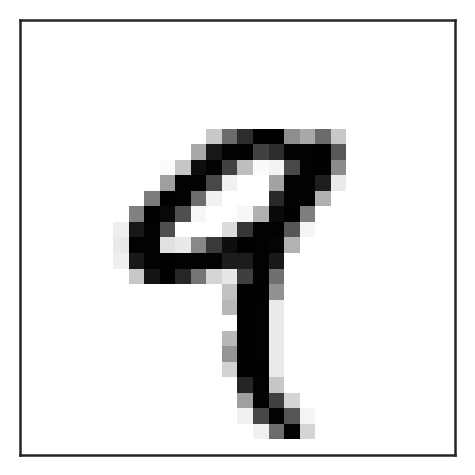

In [7]:
def display_image(im):
    plt.imshow(im.reshape((28, 28)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
display_image(X_train[4])

Basic functions:

In [6]:
def accuracy(Yhat, Y):
    return (Y.argmax(axis=1) == Yhat.argmax(axis=1)).mean()

def ReLU(X):
    return np.maximum(X, 0.0)

def drop(X, keep_prob):
    X = X.copy()
    keeps = np.random.rand(X.shape[1]) < keep_prob
    X[:, ~keeps] = 0
    X[:, keeps] *= (1/keep_prob)
    return X

def fully_connected(ninputs, noutputs):
    rv = scipy.stats.norm(0, 6 / (ninputs + noutputs))
    return rv.rvs(size=(ninputs, noutputs))

In [1]:
def average(prev, curr, β):
    return [
        β * p + (1 - β) * c
        for p, c
        in zip(prev, curr)
    ]
    
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, gradients, self.β1)        
        self.v = average(self.v, (g*g for g in gradients), self.β2)

        updates = [-αt * mi / (np.sqrt(vi) + self.ϵ) for mi, vi in zip(self.m, self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates

# Automatic Differentiation

Before we start talking about convolutional neural networks, we need to talk about [*automatic differentiation*](https://en.wikipedia.org/wiki/Automatic_differentiation).

There are different ways to implement automatic differentiation, but the idea is the same.
Given a computer-function `f(x)` that computes the math-function $f(x)$, automatic differentiation is an algorithm that produces the computer-function `df(x)` which computes the math-function $\frac{d}{dx}f(x)$.

![](https://upload.wikimedia.org/wikipedia/commons/3/3c/AutomaticDifferentiationNutshell.png)

This can accomplished when all operations made by `f(x)` are differentiable in the sense that their derivative can be computed.
If all such operations are differentiable, then `df(x)` can be produced by applying the chain-rule, similar to *back-propagation*.

In Python, automatic differentiation is implemented by several packages, but we are going to use the [AutoGrad](https://github.com/HIPS/autograd) package which is specifically designed for use with NumPy in neural network applications (`conda install autograd -c conda-forge`)

We won't actually need to implement `back_propagation(...)`, but rather, we will use `autograd` to calculate the gradients of our loss function.

## Exercise: `autograd`

`pdf(x,y)` is the the probability density function of a bivariate normal distribution with correlation coefficient `p`.

Don't forget to install: `conda install autograd`.

In [9]:
def pdf(x, y, p=0):
    return 1/(2 * np.pi * np.sqrt(1 - p**2)) * np.exp(-1/(2 * (1 - p**2)) * (x**2 -2*p*x*y + y**2))

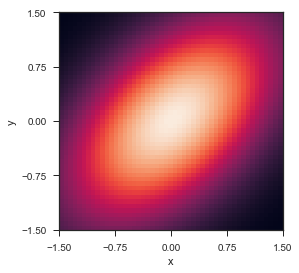

In [10]:
x = np.linspace(-1.5, 1.5)
y = np.linspace(-1.5, 1.5)
p = 0.5

X, Y = np.meshgrid(x, y)
Z = pdf(X, Y, p)

fig, ax = plt.subplots(figsize=(4, 4))
ax.pcolormesh(x, y, Z)
ax.set(xlabel='x', ylabel='y', xticks=np.linspace(x.min(), x.max(), 5), yticks=np.linspace(y.min(), y.max(), 5));

Calculate and plot the gradient of `pdf(x, y)` w.r.t `x` and `y` using two functions, `dpdfdx(x, y, p)` and `dpdfdy(x, y, p)`. Use [AutoGrad](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md).

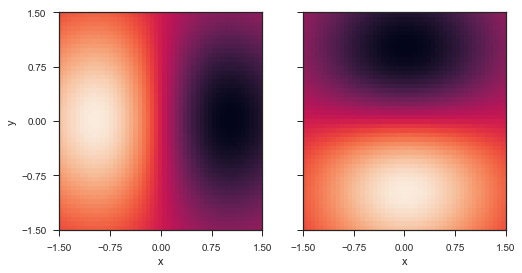

In [12]:
# remove the next line after you complete your solution to check it
%run ../solutions/CNN.py

p = 0
Zx = np.vectorize(dpdfdx)(X, Y, p) # can use elementwise_grad instead of grad and then np.vectorize is not needed
Zy = np.vectorize(dpdfdy)(X, Y, p)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
axes[0].pcolormesh(x, y, Zx)
axes[1].pcolormesh(x, y, Zy)
axes[0].set(xlabel='x', ylabel='y', xticks=np.linspace(x.min(), x.max(), 5), yticks=np.linspace(y.min(), y.max(), 5));
axes[1].set(xlabel='x');

# Convolution

Next up, we are going to discuss convolutions as they are used in structured data analysis and specifically in signal and image analysis. Note that convolutions have broader definitions and more uses, but for our purposes it is much simpler to consider them as [**local filters**](https://en.wikipedia.org/wiki/Digital_image_processing#Filtering) or **local weighted averaging**.

Given a data array $\mathbf{x}=(x_1, \ldots, x_n)$ and a filter or convolution array $\mathbf{y}=(y_{-m}, \ldots, y_0, \ldots, y_m)$ called a *kernel*, the $i$-th entry of the convolution $\mathbf{x} \ast \mathbf{y}$ of $\mathbf{x}$ by $\mathbf{y}$ is calculated by extracting the $2m+1$ entries of $\mathbf{x}$ around entry $i$, multiplying the extracted entries element-wise with $\mathbf{y}$, and summing the products:

$$
(\mathbf{x} \ast \mathbf{y})_i = \sum_{j=0}^{2m}{y_j x_{i-m+j}}
$$

## Exercise: Convolution

Implement a 1D convolution which accepts a long data 1D array `x` and a short 1D kernel array `y` and returns the convolution of `x` by `y`.

In [13]:
def myconvolve(x, y):
    pass

In [14]:
%run ../solutions/CNN.py

x = np.arange(10, dtype=int)
print(x)
y = np.ones(3, dtype=int)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[1 1 1]


In [16]:
myconvolve(x, y)

[0, 1, 3, 6, 9, 12, 15, 18, 21, 24, 17, 9]

Compare with SciPy's `convolve` function:

In [17]:
convolve(x, y, mode='full')

array([ 0,  1,  3,  6,  9, 12, 15, 18, 21, 24, 17,  9])

Note that SciPy's version uses smart optimization techniques (see `method` keyword argument), so it is much faster:

In [15]:
x = np.arange(1000, dtype=float)
y = np.ones(7, dtype=float)
%timeit myconvolve(x, y)
%timeit convolve(x, y, mode='full')

2.72 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
102 µs ± 7.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The `mode` keyword argument decides how to deal with the edges - pad with zeros (`full`), pad and trim to original size (`same`), or remove edges (`valid`).
This is a technical detail, but since the output arrays will of different sizes, it's important to be aware of the difference between the modes.

# 2D convolutions

Convolutions are very common in signal and image analysis because they are rather efficient and can represent many algorithms in which a pixel/data point is replaced by a weighted average of its neighbor pixels.

## Examples

### Blur/Smooth

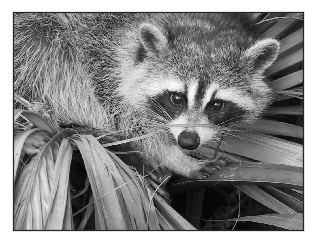

In [15]:
face = ~scipy.misc.face(gray=True)
display_image(face)

[[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]]


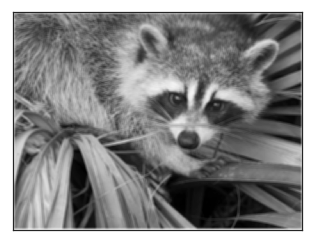

In [16]:
kernel = np.ones((10,10))
kernel /= kernel.sum()
display_image(convolve(face, kernel))
print(kernel)

### Gaussian denoising

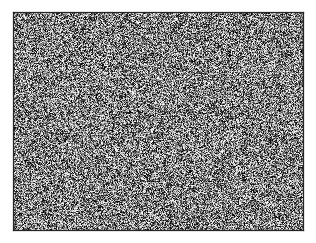

In [17]:
noise = np.random.randint(0, 255, size=face.shape)
display_image(noise)

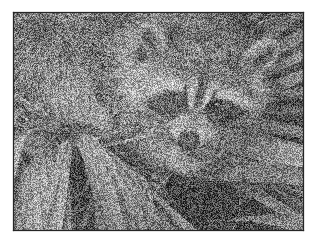

In [18]:
display_image(face + noise)

[[  1.   4.   6.   4.   1.]
 [  4.   6.  24.   6.   4.]
 [  6.  24.  36.  24.  36.]
 [  4.   6.  24.   6.   4.]
 [  1.   4.   6.   4.   1.]]


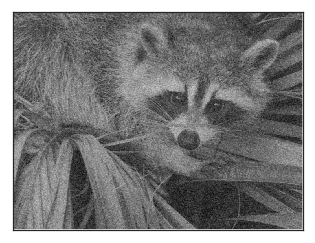

In [19]:
kernel = np.array([[1, 4, 6, 4, 1], [4, 6, 24, 6, 4], [6, 24, 36, 24, 36], [4, 6, 24, 6, 4], [1, 4, 6, 4, 1]], dtype=float)
print(kernel)
kernel /= kernel.sum()
display_image(convolve(face + noise, kernel))

### Sharpen

[[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]


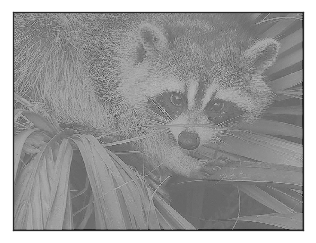

In [20]:
kernel = np.zeros((3, 3))
kernel[0,1] = kernel[1,0] = kernel[2,1] = kernel[1,2] = -1
kernel[1,1] = 5
display_image(convolve(face, kernel))
print(kernel)

### Edge detection

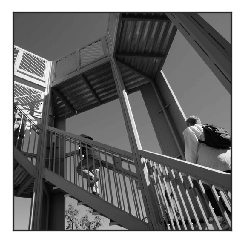

In [21]:
ascent = ~scipy.misc.ascent()
display_image(ascent)

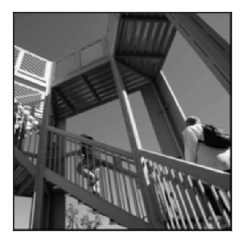

In [22]:
smoothed = convolve(ascent, np.ones((5, 5))/25)
display_image(smoothed)

[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]


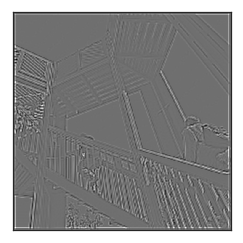

In [23]:
kernel = -np.ones((3, 3))
# kernel[0,1] = kernel[1,0] = kernel[2,1] = kernel[1,2] = -1
kernel[1,1] = 8
display_image(convolve(smoothed, kernel))
print(kernel)

### Smoothing + edge detection

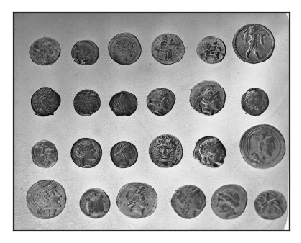

In [24]:
from skimage.data import coins
coins = coins()
display_image(coins)

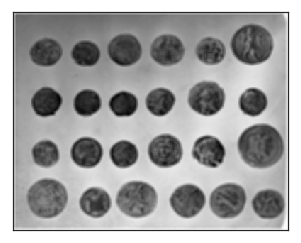

In [25]:
smoothed = convolve(coins, np.ones((5, 5), dtype=float)/25)
display_image(smoothed)

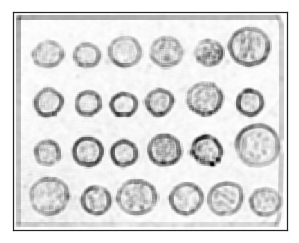

In [26]:
kernel = -np.ones((3, 3))
kernel[1,1] = -kernel.sum() - 1
edges = ReLU(convolve(smoothed, kernel))
edges = convolve(edges, np.ones((7, 7), dtype=float)/49)
display_image(edges)

### Exercise: Gradient detection

Write a kernel for gradient detection.
A [gradient in a 2D array](https://en.wikipedia.org/wiki/Image_gradient) (e.g. image) is defined as the directional change in the intensity.
For pixel $x_{i,j}$ at row $i$ and column $j$, the gradient at the horizontal direction $\nabla_{i,j}^h$ is 
$$
\nabla_{i,j}^h = x_{i,j+1}-x_{i,j-1}
$$
and the vertical gradient $\nabla_{i,j}^v$ can be similarly calculated by shifting $i$.

Calculate the horizontal gradient.

In [36]:
def horizontal_gradient(im):
    pass

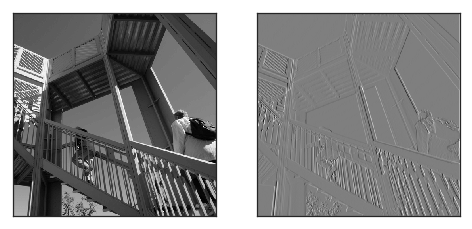

In [39]:
%run ../solutions/CNN.py
gradient = horizontal_gradient(ascent)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
display_image(ascent, ax=axes[0])
display_image(gradient, ax=axes[1])

# Convolutional neural network

In a convolutional neural network we replace some of the fully-connected layers with convolutional layers in which we apply several convolutional filters to the input.

We'll start by implementing a two-layer network in which the first layer is a convolutional layer and the second layer is a fully-connected softmax layer:
$$
\mathbf{Z_1} = \mathbf{X_1} \ast \mathbf{W_1} + b_1 \\
\mathbf{X_2} = pool({\tanh{(\mathbf{Z_1})}}) \\
\mathbf{Z_2} = \mathbf{X_2} \cdot \mathbf{W_2} + b_2 \\
\mathbf{\widehat Y} = softmax(\mathbf{Z_2})
$$

Here we also introduce a bias term $b_k$, which can also be considered a prior distributionn (in Bayesian terms) or an intercept coefficient (this is, after all, still a linear model).

In the CNN model our data (the layers) is no longer 2D (`(nsamples, nfeatures)`).
It is now a 4D tensor with shape `(nsamples, width, height, nchannels)`, where `nchannels` can be, for example, 3 for a color image, or 10 for the output of 10 filters.

The input $\mathbf{X_1}$ shape is `(-1, 28, 28, 1)`.
The first convolutional layer is generated by convolution with $\mathbf{W_1}$ with shape `(5, 5, 1, 10)` for 1 input channel, 10 output channgels, and 5x5 kernels.
We use `mode='full'` for the convolution, which increases the outputs 2 extra pixels in every edge (half of the kernel size), which we then crop out to get the convolution output $\mathbf{Z_1} = \mathbf{W_1 \ast X_1} + b_1$ shape `(-1, 28, 28, 10)` (and $b_1$ has shape `(10,)`).

In [10]:
def kernel(width, height, ninput, noutput):
    rv = scipy.stats.norm(0, 6 / (ninput + width + height + noutput))
    return rv.rvs(size=(width, height, ninput, noutput))

def convolution(W, X):
    if X.ndim == 3:
        X = X[:, :, :, np.newaxis]
    Z = convolve(X, W, axes=([1, 2], [0, 1]), dot_axes=([3], [2]), mode='full')
    # 'valid' will lose W.shape[0]/2 pixels from width and W.shape[1]/2 pixels from height
    # 'same' is not supported by autograd
    Z = np.swapaxes(np.swapaxes(Z, 1, 2), 2, 3) # n, c, w, h -> n, w, h, c
    _, w, h, _ = X.shape
    dw, dh = W.shape[0]//2, W.shape[1]//2    
    return Z[:, dw:w+dw, dh:h+dh, :]

## Pooling

The new element here is the $pool$ function, which applies **pooling** - the combination of several neurons/pixels into a single one.

We will use a common pooling approach called *2x2 max pooling* in which every 2x2 square of pixels is replaced by its maximal value.

![](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

Pooling adds another non-linear component, reduces the size of the layers, and thus the number of paramters, and reduces over-fitting by approximating the location of feautures.

Since thd activation function operates element-wise without impacting the shape, the output of the activation and pooling $\mathbf{X_2}$ has shape `(-1, 14, 14, 10)`.

The following uses some NumPy trickery to implement 2x2 max pooling in a way that is both efficient and differentiable by AutoGrad.

In [11]:
def max_pool(X):
    # https://stackoverflow.com/a/31975845
    n, h, w, c = X.shape
    Z = X.reshape(n, h//2, 2, w//2, 2, c).swapaxes(2, 3).reshape(n, h//2, w//2, 4, c)
    Z = Z.max(axis=3)
    return Z

The readout layer includes a fully-connected layer with the softmax function ([multinomial logistic model](softmax-model.ipynb))

In this stage we flatten the layer from shape `(-1, 14, 14, 10)` to shape `(-1, 1960)` and multiply with a matrix $\mathbf{W_2}$ of shape `(1960, 10)` (and add a `(10,)` shaped $b_2$), to get the output layer $\mathbf{\widehat Y}$ with shape `(-1, 10)`.

We use the log of the softmax function here because it is more computationally stable:

In [12]:
def logsoftmax(X):
    max_X = np.max(X)
    logsumexp = max_X + np.log(np.sum(np.exp(X - max_X), axis=1, keepdims=True))
    return X - logsumexp

![](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

## Exercise: Feed Forward

Implement a `feed_forward(Ws, bs, X, keep_prob)` function that returns just $\mathbf{\widehat Y}$ (we don't need all the layers because we will use AutoGrad for the back propagation).

Remember the model:
$$
\mathbf{Z_1} = \mathbf{X_1} \ast \mathbf{W_1} + b_1 \\
\mathbf{X_2} = pool({\tanh{(\mathbf{Z_1})}}) \\
\mathbf{Z_2} = \mathbf{X_2} \cdot \mathbf{W_2} + b_2 \\
\mathbf{\widehat Y} = softmax(\mathbf{Z_2})
$$

In [13]:
def feed_forward(Ws, bs, X, keep_prob=1):
    # Your code here
    return np.ones((X.shape[0], 10))/10

In [14]:
def predict(Ws, bs, X):
    if X.ndim == 1:
        X = X[np.newaxis, :]
    return feed_forward(Ws, bs, X)

def display_prediction(idx=None):
    if idx is None:
        idx = np.random.randint(0, X_test.shape[0])
    print(predict(Ws, bs, X_test[idx, :].reshape(-1, 28, 28)).argmax())
    return display_image(test_images[idx, :, :])

In [15]:
%run -i ../solutions/CNN.py

W1 = kernel(5, 5, 1, 3)
W2 = fully_connected(14 * 14 * 3, ncats) # 1/2 of pixles lost by pooling
Ws = [W1, W2]
b1 = np.ones(3) / 3
b2 = np.ones(ncats) / ncats
bs = [b1, b2]

print("Accuracy:", accuracy(predict(Ws, bs, X_test[:100].reshape(-1, 28, 28)), Y_test[:100]))

Accuracy: 0.1


# Training a CNN

To train the CNN we still use cross entropy as aloss function, but we are going to introduce a [*regularization*](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29) term.

In general, regularization is a way to add some information or constraint to the training process by adding another term to the loss function.

In this case, we want to prevent the parameters $\mathbf{W_k}, b_k$ from becoming too large.
So we redefine the loss function to be
$$
loss(\mathbf{W_1}, \mathbf{W_2}, b_1, b_2 \mid \mathbf{X_1}, \mathbf{Y}) =
C(\mathbf{W_1}, \mathbf{W_2}, b_1, b_2 \mid \mathbf{X_1}, \mathbf{Y}) + 
\lambda (||\mathbf{W_1}||, ||\mathbf{W_2}||, ||b_1||, ||b_2||)
$$

$\lambda$ is a meta-parameter that determines the relative weight given to the cross entropy term and the regularization term.

In [16]:
def cross_entropy(logYhat, Y):
    ylogy = Y * logYhat
    return -ylogy.mean()

def loss(Ws, bs, X, Y, λ=0, **kwargs):
    logYhat = feed_forward(Ws, bs, X)
    return cross_entropy(logYhat, Y) + λ * norm(Ws, bs)

The norms can be defined is different ways; we just take the *sum of the squares of all the entries of all the matrices $\mathbf{W_k}$ and arrays $b_k$*. 

We implement a function `norm(Ws, bs)` that calculates to sum of the squares of all the parameters.

In [17]:
def _norm(Ws, bs):
    return sum((W**2).sum() for W in Ws) + sum((b**2).sum() for b in bs)

def norm(Ws, bs):
    W = np.concatenate((W.ravel() for W in Ws))
    b = np.concatenate((b.ravel() for b in bs))
    return W @ W + b @ b

In [18]:
Ws = [np.random.random(size=(5,5,64)), np.random.random(size=(5,5,32))]
bs = [np.ones(64), np.ones(32)]

assert np.isclose(norm(Ws, bs), _norm(Ws, bs))
%timeit _norm(Ws, bs)
%timeit norm(Ws, bs)

17.7 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
15.5 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Back propagation with automatic differentiation

This time we won't waste write the back-propagation ourselves because back-propagating convolutions is a hassle and we have a clean and easy way to do it.

We use AutoGrad to produce functions for $\Big(\frac{\partial C}{\partial W_1}, \frac{\partial C}{\partial W_2}\Big)$ and $\Big(\frac{\partial C}{\partial b_1}, \frac{\partial C}{\partial b_2}\Big)$.
We then define `back_propagation` to return the results of these functions as a tuple.

In [19]:
dlossdW = grad(loss, 0)
dlossdb = grad(loss, 1)

def back_propagation(*args, **kwargs):
    return dlossdW(*args, **kwargs), dlossdb(*args, **kwargs)

## Initializing and training the network

The `trainer` generator function is very similar to what we previously used, only we have two optimizers, one for `Ws` and one for `bs`.

In [106]:
def trainer(Ws, bs, X, Y, batch_size=50, keep_prob=1, λ=0):
    optimizer_W, optimizer_b = AdamOptimizer(), AdamOptimizer() # create optimizers
    nsamples = X.shape[0]
    t = 0
    while True:
        t += 1
        # get next batch
        start = (t * batch_size) % nsamples
        stop = start + batch_size
        batch_idx = range(start, stop)
        X_, Y_ = X[batch_idx, :], Y[batch_idx, :]
        # calculate gradients
        dWs, dbs = back_propagation(Ws, bs, X_, Y_, keep_prob=keep_prob, λ=λ)
        # calculate updates
        ΔWs = optimizer_W.send(dWs)
        Δbs = optimizer_b.send(dbs)
        # apply updates
        for W, b, ΔW, Δb in zip(Ws, bs, ΔWs, Δbs):
            W += ΔW
            b += Δb
        yield t

We create one hidden convolutional layers with 10 convolution filters, each with a separate 5x5 kernel for a total of 10x5x5=250 parameters, and a layer with 10x14x14=1960 neurons (10 images, each 14x14 because of the pooling).
The number of filters and the kernel sizes are meta-parameters of the model, part of the network architecture.

The readout layer is, as before, a fully connected softmax layer, with a weight matrix of size 1960x10=19600.

In total we have 250+19600=19850 parameters, compared to 728x1000+1000x10 = 738000 we has in the two-later FFN.
This is an order of magnitude reduction of memory (37x), so if we can get even similar accuracy we should be happy.

In [101]:
nfilters = 10
W1 = kernel(5, 5, 1, nfilters)
W2 = fully_connected(14 * 14 * nfilters, ncats) # 1/2 of pixles lost by pooling
Ws = [W1, W2]
b1 = np.ones(nfilters) / nfilters
b2 = np.ones(ncats) / ncats
bs = [b1, b2]

In [102]:
print("Accuracy:", accuracy(predict(Ws, bs, X_test.reshape(-1, 28, 28)), Y_test))

Accuracy: 0.0587


Let's train the model. This is very slow, though - you might want to run it on a dedicated high-CPU computer (you can quickly get one on [Crestle](http://crestle.com)).

In [61]:
train = trainer(Ws, bs, X_train.reshape(-1, 28, 28), Y_train, keep_prob=0.5, λ=1e-3)
for t in train:
    if t == 1100: break
    if t % 100 == 0:
        acc = accuracy(predict(Ws, bs, X_test.reshape(-1, 28, 28)), Y_test)
        print("Accuracy ({}): {}".format(t, acc))

Accuracy (100): 0.8628
Accuracy (200): 0.8983
Accuracy (300): 0.911
Accuracy (400): 0.9191
Accuracy (500): 0.9149
Accuracy (600): 0.9274
Accuracy (700): 0.9178
Accuracy (800): 0.9276
Accuracy (900): 0.9311
Accuracy (1000): 0.9316
Accuracy (1100): 0.9185


In [62]:
np.savez_compressed('../data/CNN_MNIST_2layer.npz', Ws=Ws, bs=bs)

We didn't outperform the FFN model, but we have a comparable model with a significantly smaller memory footprint, and...

# The rotation problem

Because convolutions are local operators, they are invariant to rotation and [translation](https://en.wikipedia.org/wiki/Translation_%28geometry%29) (shifting in space).
This is a very powerful property when dealing with spatial or structured data.
Of course, even a human can get confused between 2 and 4 or 6 and 9 when rotated, and if we want to be rotate-proof we should probably *augment* our dataset with rotated images to train on those, too.

In [44]:
with np.load('../data/CNN_MNIST_2layer.npz') as d:
    Ws = d['Ws']
    bs = d['bs']

9


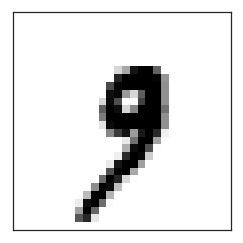

In [68]:
im = test_images[1000, :, :]
print(predict(Ws, bs, im[np.newaxis, :, :]).argmax())
display_image(im)

9


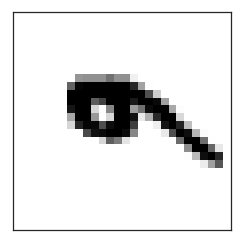

In [69]:
rotated = scipy.ndimage.rotate(im, 90)
print(predict(Ws, bs, rotated[np.newaxis,:,:]).argmax())
display_image(rotated)

# Two convolutional layers

To beat the FFN, we will use two hidden convolutional layers with more filters.

The first layer will have 32 5x5 filters, thus it will get 728 neurons and output 14x14x32=6272 neuros.

The second layer will have 64 5x5 filters, thus it will get 6272 neurons and output 7x7x64=3136 neuros.

The readout layer (fully-connected softmax layer) will connect these 3136 neurons to the 10 category neurons.

In total, we will have 32x5x5 + 32 + 64x5x5 + 64 + 3136x10 + 10 = 33866 parameters, compared to the single-hidden layer model we previously used that had 19870, so roughly 1.7-fold increase in memory.

In [70]:
nfilters1 = 32
nfilters2 = 64
W1 = kernel(5, 5, 1, nfilters1)
W2 = kernel(5, 5, nfilters1, nfilters2)
W3 = fully_connected(7 * 7 * nfilters2, ncats)
Ws = [W1, W2, W3]
b1 = np.ones(nfilters1) / nfilters1
b2 = np.ones(nfilters2) / nfilters2
b3 = np.ones(ncats) / ncats
bs = [b1, b2, b3]

In [79]:
train = trainer(Ws, bs, X_train.reshape(-1, 28, 28), Y_train, keep_prob=0.5, λ=1e-3)
for t in train:
    if t == 1100: break
    if t % 100 == 0:
        acc = accuracy(predict(Ws, bs, X_test.reshape(-1, 28, 28)), Y_test)
        print("Accuracy ({}): {}".format(t, acc))

Accuracy (100): 0.911
Accuracy (200): 0.9438
Accuracy (300): 0.9468
Accuracy (400): 0.9554
Accuracy (500): 0.9517
Accuracy (600): 0.9633
Accuracy (700): 0.9511
Accuracy (800): 0.9568
Accuracy (900): 0.9582
Accuracy (1000): 0.9614
Accuracy (1100): 0.9443


You can see that the two-hidden-layer model outpreforms the FFN model and both single-hidden layer models.
It also takes longer to train, which is why we should figure out how to train these models with a dedicated softward library a powerful CPU or GPU.

In [83]:
np.savez_compressed('../data/CNN_MNIST_3layer.npz', Ws=Ws, bs=bs)

In [71]:
with np.load('../data/CNN_MNIST_3layer.npz') as d:
    Ws = d['Ws']
    bs = d['bs']

9


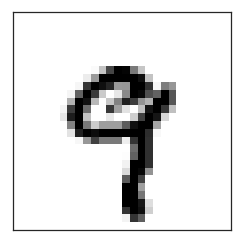

In [75]:
display_prediction()

# References

- [Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville](http://www.deeplearningbook.org), ch. 9 - offers a comprehensive introduction to CNNs.
- [Deep Learning: Technical introduction by Thomas Epelbaum](https://github.com/tomepel/Technical_Book_DL), ch. 5 - offers a very technical perspective with full derivation of all the formulas.

Both books are available online for free.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)